# 1. Library 

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]

tss_annotation = doc['tss_annotation']


import os
os.chdir
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 15)


# 2. Load and Preprocessing

## Read in expression matrix

In [3]:
tissues_expr = pd.read_csv("Results/merged/tissues.merge.peaksexpression.log10",sep="\t",index_col=0)
tissues_expr.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
0,0.213256,0.000000,0.191009,0.177054,1.379905,1.92993,0.192445,0.292073,0.000000,0.000000,0.191908,0.289548,0.000000
1,0.000000,0.568176,0.658306,0.704141,0.000000,0.00000,0.365353,0.875407,0.211156,0.000000,0.160073,0.206016,0.000000
2,0.000000,0.272654,0.191009,0.649540,1.269561,0.00000,0.285237,0.439970,0.000000,0.822168,0.251895,0.377071,0.299942
3,0.213256,0.582778,0.592983,0.556972,0.347363,0.00000,0.633209,0.256951,0.000000,0.536558,0.300486,0.216445,0.380588
4,0.858835,1.743575,1.998797,1.219034,0.698374,0.00000,1.707648,0.729080,0.945179,0.641474,1.198274,0.838893,1.141311


### Read in promoter output

In [4]:
tss_meta = pd.read_csv("Results/output/TSS1.exp.meta",sep="\t",index_col=0)
tss_meta["Name"] = tss_meta.index
tss_meta.set_index("ID",inplace=True)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name
ID,,,,,,,,
288840,CHO,0b00,NaN,RRP7A,gene_2,asmbl_4,1.0,p1@RRP7A_gene_2_asmbl_4
298180,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,RRP7A,gene_2,asmbl_10,1.0,p1@RRP7A_gene_2_asmbl_10
160866,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,SERHL,gene_1_4,asmbl_14,1.0,p1@SERHL_gene_1_4_asmbl_14
124466,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,POLDIP3,gene_3_1,asmbl_17,1.0,p1@POLDIP3_gene_3_1_asmbl_17
27913,BMDM1hKLA,0b10,NaN,POLDIP3,gene_3_1,asmbl_18,1.0,p1@POLDIP3_gene_3_1_asmbl_18


## Extract promoter peaks

In [5]:
prom_tissue = tissues_expr.loc[tissues_expr.index.isin(tss_meta.index)]
prom_tissue.head()

,Heart,Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1hKLA,Brain,Lung,Liver,BMDMwt,Muscle,Kidney,Pancreas
3,0.213256,0.582778,0.592983,0.556972,0.347363,0.000000,0.633209,0.256951,0.000000,0.536558,0.300486,0.216445,0.380588
4,0.858835,1.743575,1.998797,1.219034,0.698374,0.000000,1.707648,0.729080,0.945179,0.641474,1.198274,0.838893,1.141311
5,0.401387,1.307673,1.395354,0.648333,0.000000,0.000000,0.934077,0.962160,0.864244,0.328380,1.110493,0.902631,1.001595
6,0.815153,0.519195,1.187007,0.253253,0.418683,0.000000,0.285242,0.256951,1.479573,0.559907,0.964390,0.900018,0.825823
8,0.700386,0.681902,0.878080,0.600699,0.213637,0.848805,0.858705,0.748833,0.441517,1.089905,0.633441,0.483976,0.622968


## Create median and max values


In [6]:
tss_meta["Median"] = prom_tissue.median(axis=1)
tss_meta["Max"] = prom_tissue.max(axis=1)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max
ID,,,,,,,,,,
288840,CHO,0b00,NaN,RRP7A,gene_2,asmbl_4,1.0,p1@RRP7A_gene_2_asmbl_4,0.000000,0.121276
298180,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,RRP7A,gene_2,asmbl_10,1.0,p1@RRP7A_gene_2_asmbl_10,0.327122,1.042989
160866,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,SERHL,gene_1_4,asmbl_14,1.0,p1@SERHL_gene_1_4_asmbl_14,1.652309,1.963852
124466,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,POLDIP3,gene_3_1,asmbl_17,1.0,p1@POLDIP3_gene_3_1_asmbl_17,1.553687,2.168035
27913,BMDM1hKLA,0b10,NaN,POLDIP3,gene_3_1,asmbl_18,1.0,p1@POLDIP3_gene_3_1_asmbl_18,0.000000,0.619093


### Removing 0s when calculating the median

In [7]:
tss_meta["Median no 0"] = prom_tissue.apply(lambda x: x[x>0].median(),axis=1)
tss_meta["Only 1"] = (prom_tissue>0).sum(axis=1) <= 1

### Create a gene-of-interest list inspired by 
#### A promoter-level mammalian expression atlas Figure 2

In [2]:
goi = ["ALB","GFAP","H19","IRF9","TP53"]

In [22]:
tss_meta[~tss_meta["Only 1"]][tss_meta[~tss_meta["Only 1"]]["Gene"].isin(goi)]

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,Name,Median,Max,Median no 0,Only 1
ID,,,,,,,,,,,,
408720,"Heart,Spleen,MiscOrgans,FemaleReproductive,BMD...",0b11,NaN,ALB,gene_5002,asmbl_14590,1.0,p1@ALB_gene_5002_asmbl_14590,1.379709,2.305476,1.400656,False
160945,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,IRF9,gene_12904_2,asmbl_36993,1.0,p1@IRF9_gene_12904_2_asmbl_36993,1.782381,2.305093,1.782381,False
145207,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO...",0b11,NaN,IRF9,gene_12904_2,asmbl_36993,1.0,p2@IRF9_gene_12904_2_asmbl_36993,0.498639,1.622183,0.750303,False
130892,"Spleen,MiscOrgans,FemaleReproductive,CHO,BMDM1...",0b11,NaN,TP53,gene_27685,asmbl_78094,1.0,p1@TP53_gene_27685_asmbl_78094,0.372309,0.771269,0.429426,False
167396,"MiscOrgans,Brain,Muscle,Pancreas,Heart",0b11,NaN,GFAP,gene_30072,asmbl_85177,1.0,p1@GFAP_gene_30072_asmbl_85177,0.000000,1.093027,0.616498,False


# 3. Plotting

## Plot the two

### Without removing 0s

(0, 2)

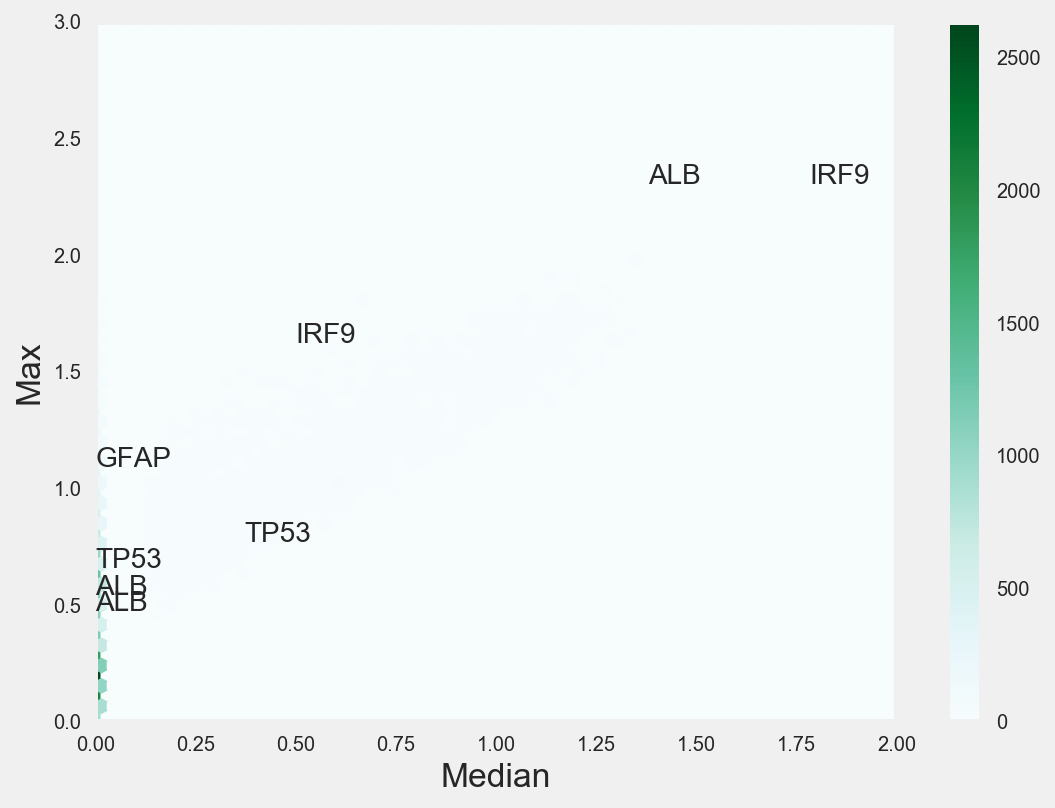

In [8]:
tss_meta.plot.hexbin(x="Median",y="Max")

for ind,val in tss_meta[tss_meta["Gene"].isin(["ALB","GFAP","H19","IRF9","TP53"])].iterrows():
    val["Median"]
    plt.gca().text(val["Median"],val["Max"],val["Gene"])

plt.ylim([0,3])
plt.xlim([0,2])

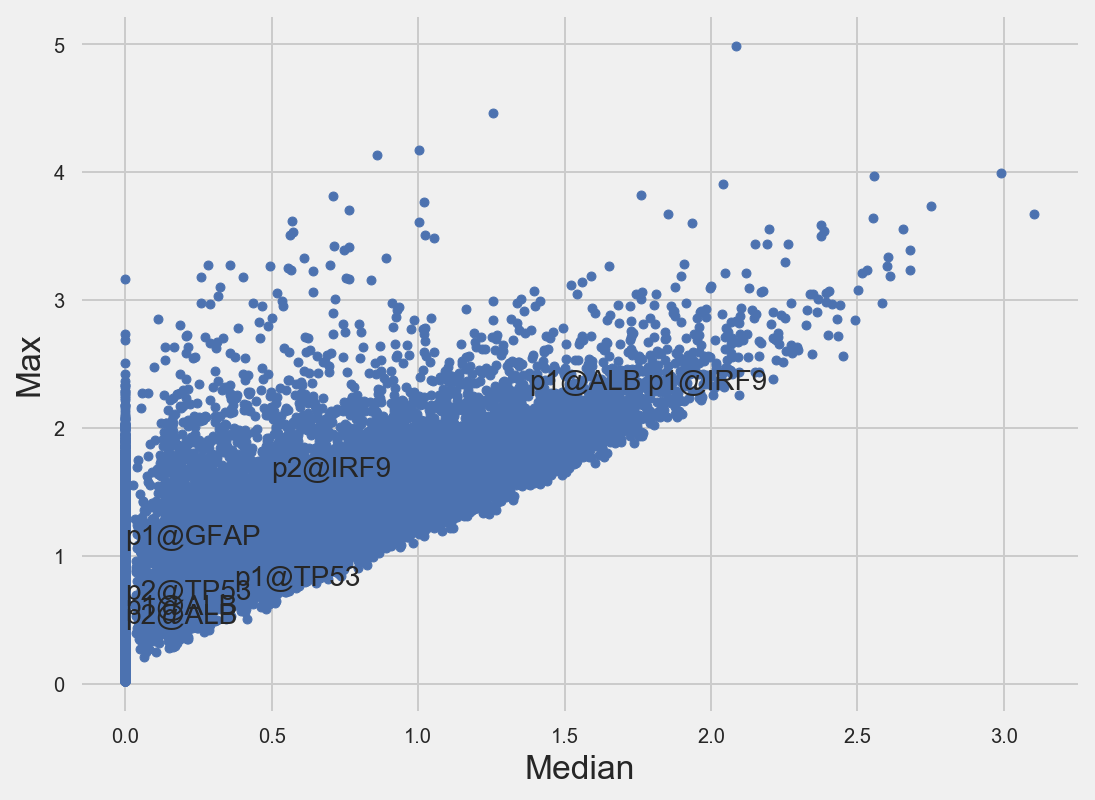

In [9]:
tss_meta.plot.scatter(x="Median",y="Max")

for ind,val in tss_meta[tss_meta["Gene"].isin(["ALB","GFAP","H19","IRF9","TP53"])].iterrows():
    val["Median"]
    plt.gca().text(val["Median"],val["Max"],val["Name"].split("_")[0])

# plt.ylim([0,3])
# plt.xlim([0,2])

## Median on values that had a peak (so no 0s included)

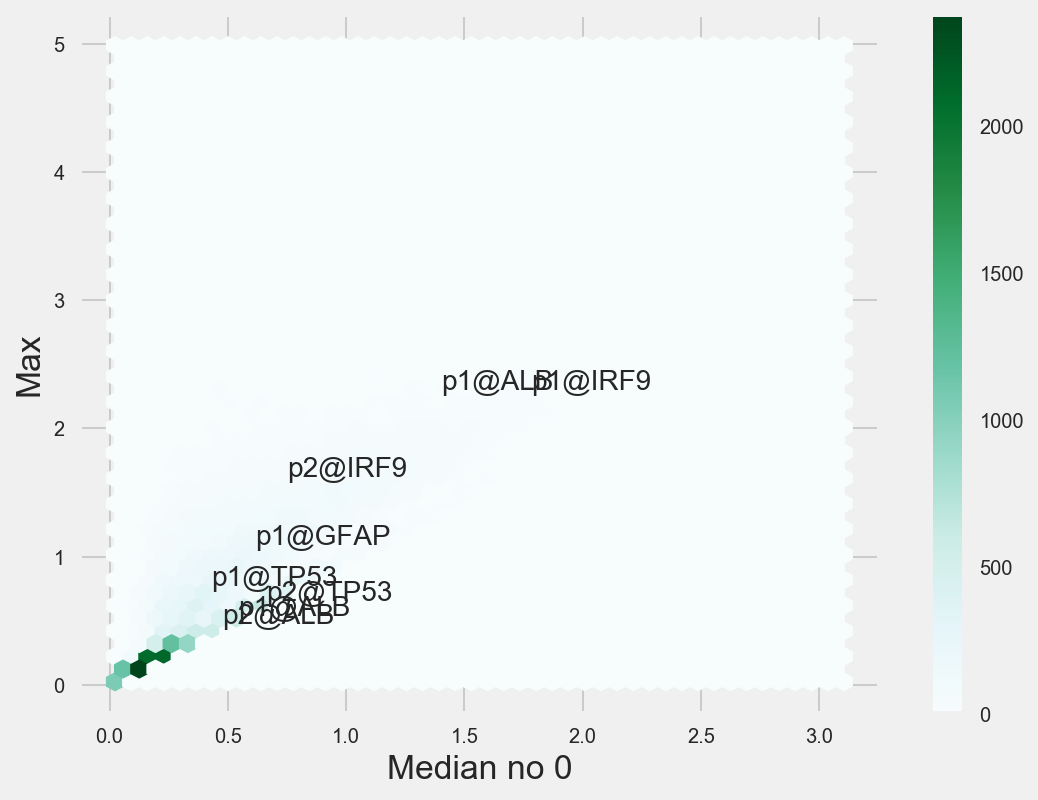

In [11]:
tss_meta.plot.hexbin(x="Median no 0",y="Max",gridsize=45)
# plt.xlim([0,1])
# plt.ylim([0,1])
for ind,val in tss_meta[tss_meta["Gene"].isin(goi)].iterrows():
    val["Median no 0"]
    plt.gca().text(val["Median no 0"],val["Max"],val["Name"].split("_")[0])

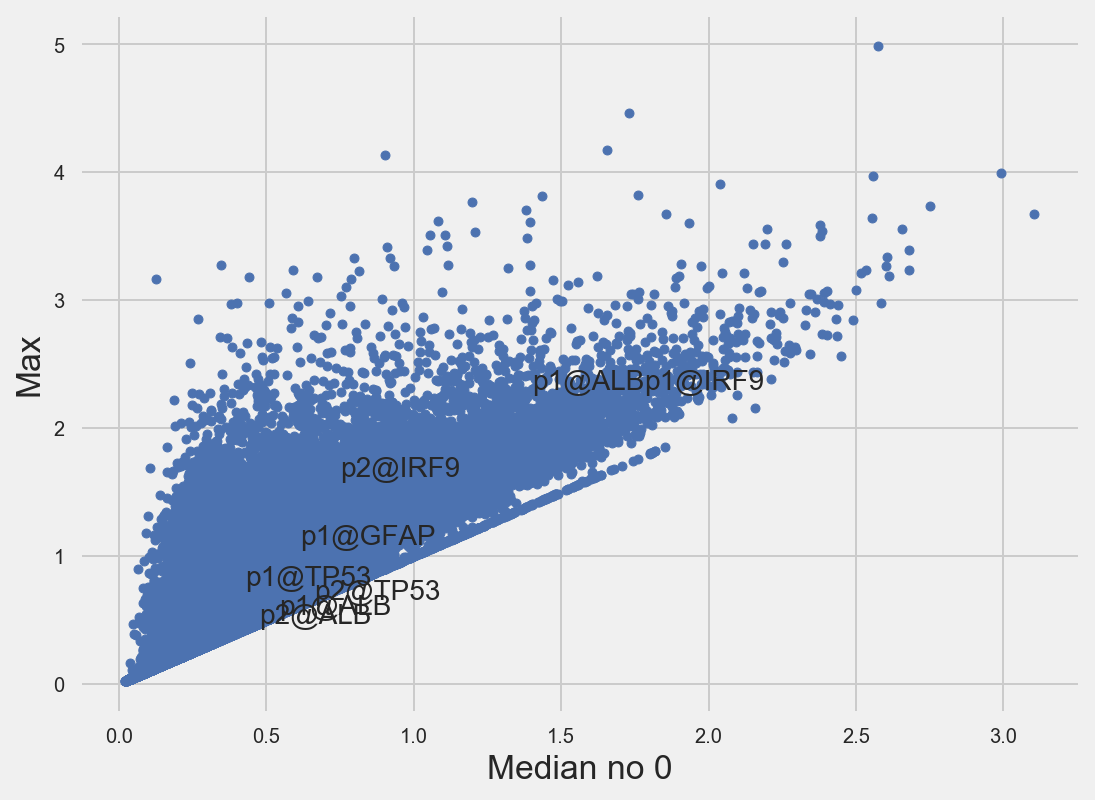

In [13]:
tss_meta.plot.scatter(x="Median no 0",y="Max")
for ind,val in tss_meta[tss_meta["Gene"].isin(goi)].iterrows():
    val["Median no 0"]
    plt.gca().text(val["Median no 0"],val["Max"],val["Name"].split("_")[0])

# plt.xlim([0,1])
# plt.ylim([0,1])

## Removing points that were only in one tissue

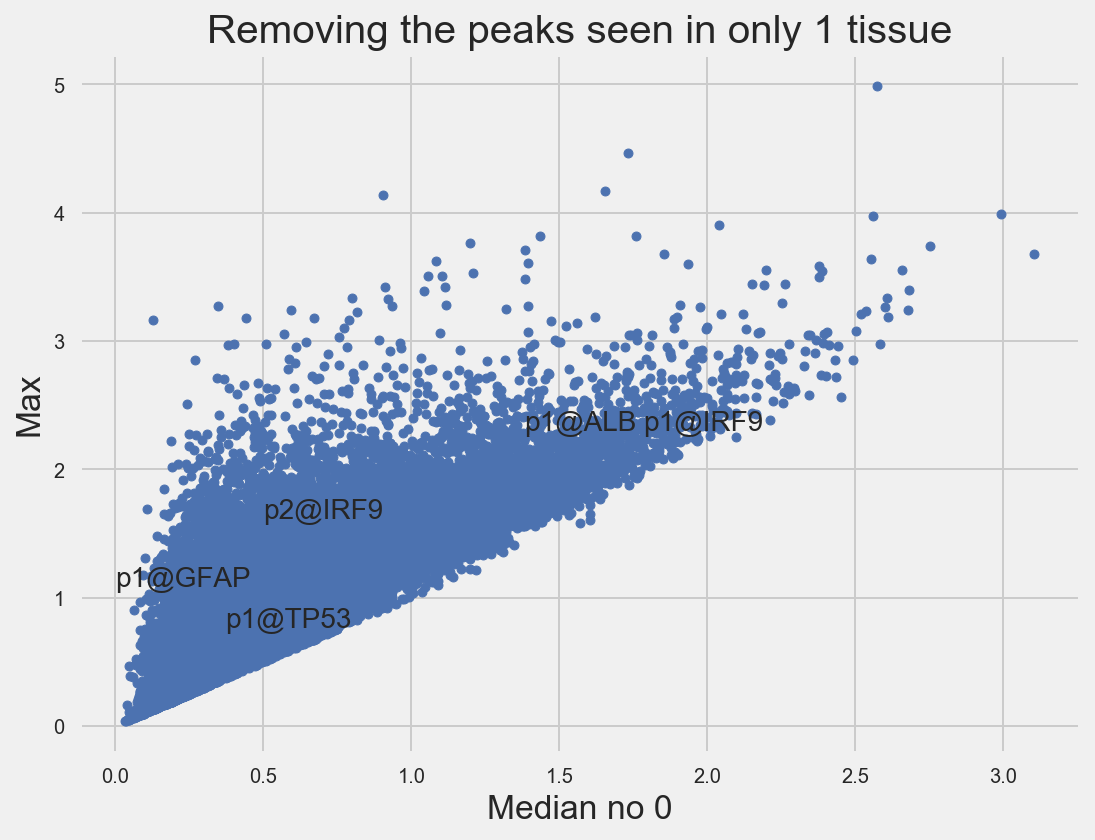

In [23]:
tss_meta[~tss_meta["Only 1"]].plot.scatter(x="Median no 0", y="Max")
plt.title("Removing the peaks seen in only 1 tissue")

for ind, val in tss_meta[~tss_meta["Only 1"]][tss_meta[~tss_meta["Only 1"]][
        "Gene"].isin(goi)].iterrows():
    val["Median"]
    plt.gca().text(val["Median"], val["Max"], val["Name"].split("_")[0])

(0, 3)

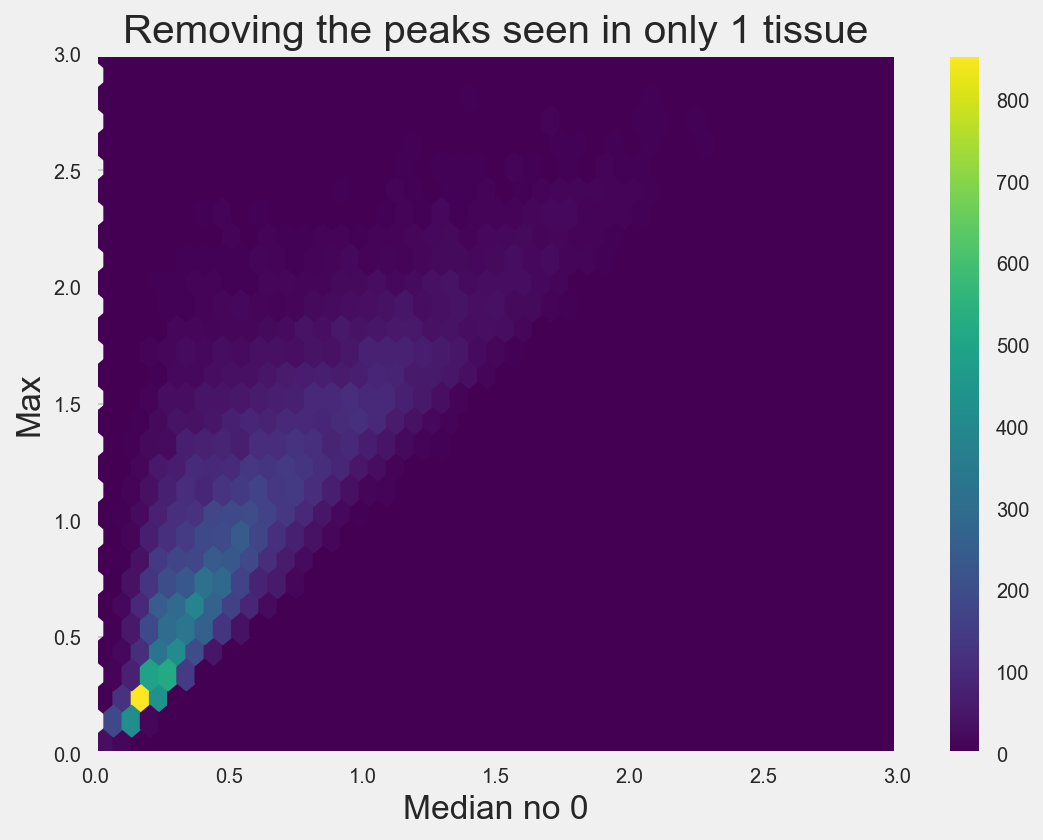

In [24]:
tss_meta[~tss_meta["Only 1"]].plot.hexbin(
    x="Median no 0", y="Max", gridsize=45, cmap=plt.cm.viridis)
plt.title("Removing the peaks seen in only 1 tissue")
plt.xlim([0, 3])
plt.ylim([0, 3])

(0, 3)

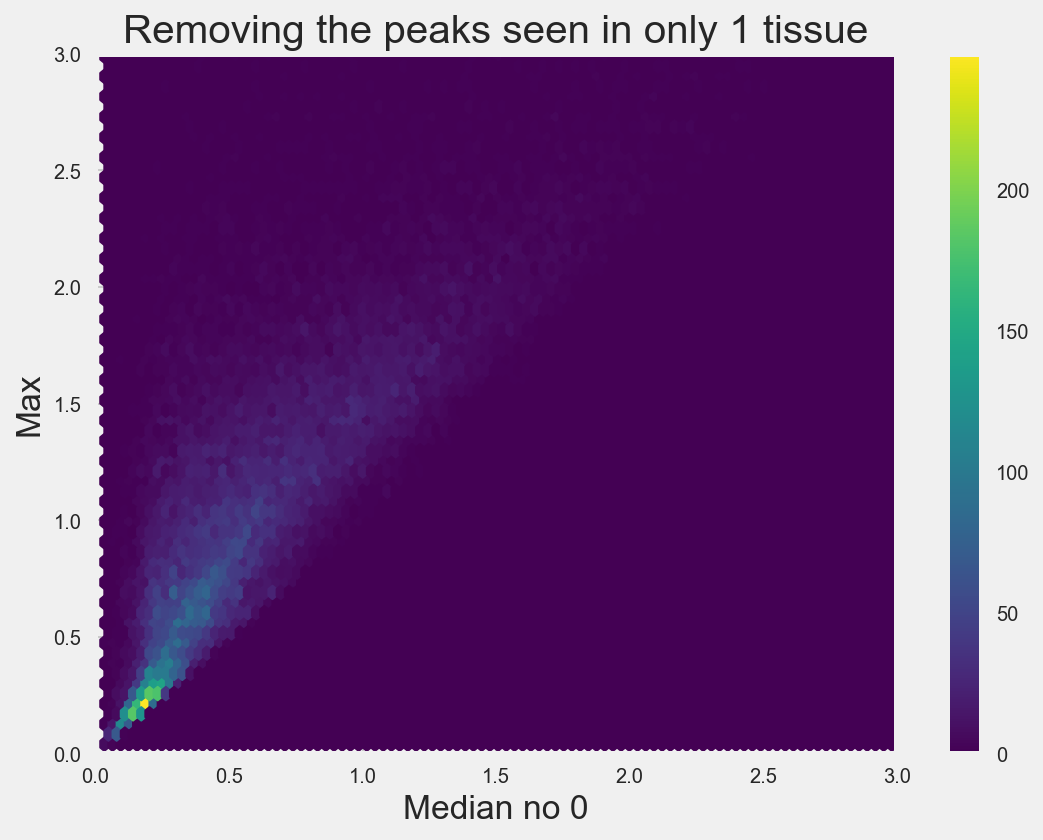

In [25]:
tss_meta[~tss_meta["Only 1"]].plot.hexbin(
    x="Median no 0", y="Max", gridsize=100, cmap=plt.cm.viridis)
plt.title("Removing the peaks seen in only 1 tissue")
plt.xlim([0, 3])
plt.ylim([0, 3])